# Static Labor Supply

# Setup

In [2]:
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt

from consav.linear_interp import interp_1d

## Utility and Parameters

In [3]:
# utility
def util(h,w,N,par):
    C = income(h,w,N,par)
    return (C**(1+par.eta))/(1+par.eta) - par.beta*(h**(1+par.gamma))/(1+par.gamma)

# income
def income(h,w,N,par):
    return (1-par.tau)*w*h + N

# solution
def solve(N,par):

    h = np.nan + np.ones(par.w_grid.size)
    for iw,w in enumerate(par.w_grid):
        obj = lambda h: -util(h,w,N,par)
        h_init = np.array([2.0])

        bounds = ((0.0,200.0),)

        res = minimize(obj,h_init,bounds=bounds,method='SLSQP')
        h[iw] = res.x[0]
        
    return h

In [4]:
# parameters 
class par: pass
par.beta = 0.1
par.eta = -2.0
par.gamma = 2.5
par.tau = 0.1

## In-Class Exercise
1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

## Solve Static Model on Grid of Wages, $w$

In [13]:
# find optimal labor supply as a function of wages
par.w_grid = np.linspace(1.0,20.0,100)

N = 5.0 # non-labor income. Important for strength of income effect
h = solve(N,par)

N_alt = 7.0
h_alt = solve(N_alt, par)

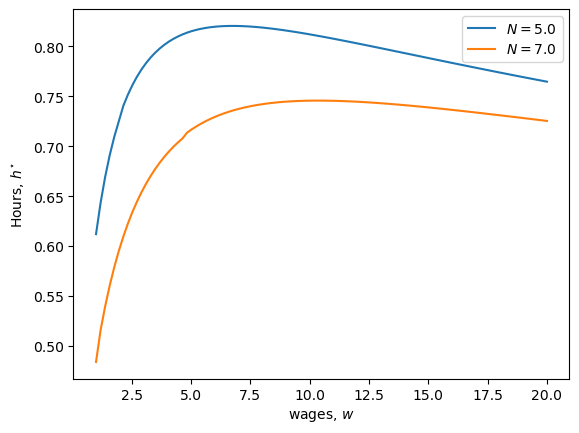

In [14]:
# plot solution
fig, ax = plt.subplots()
ax.plot(par.w_grid,h, label=f'$N={N}$');
ax.plot(par.w_grid, h_alt, label=f'$N={N_alt}$')
ax.set(xlabel='wages, $w$',ylabel='Hours, $h^{\star}$');
ax.legend();

**Question 1:** At what level of wages does the income effect start to dominate?

**Question 2:** Plot the solution for different levels of non-labor income, $N$. How does the optimal behavior change? What about the income effect?

**Q2**: For higher N, labor supply is lower ceteris paribus. But point where income effect starts to dominate shifts upwards. Marginal value of wealth is smaller, so income effect of wages is smaller. Conclusion: The higher the wealth, the smaller the income effect of tax rates. 

## Simulation
To simulate from this model, we need a level of non-labor income, $N$, and a wage level, $w$. We will primarely focus on the latter. 

The simulation here is simple, since we just need to *interpolate* the found solution for the new value of $w$ which is likely not on the grid `par.w_grid`, for which we have calculated the solution.

In [11]:
def simulate(wi,h,par):
    return interp_1d(par.w_grid,h,wi)

## Elasticities
**Marshall**

In [15]:
# Theoretical Marshall elasticities
S = ((1-par.tau)*par.w_grid*h) / ((1-par.tau)*par.w_grid*h + N)
ela_M = (1+par.eta*S) / (par.gamma - par.eta*S)

In [16]:
# Simulate one point on this curve. One observation is enough because no heterogeneity
w = 5.0
h_sim_base = simulate(w,h,par) 
h_sim_1pct = simulate(w*1.01,h,par) 

ela_M_sim = (h_sim_1pct-h_sim_base)/h_sim_base*100

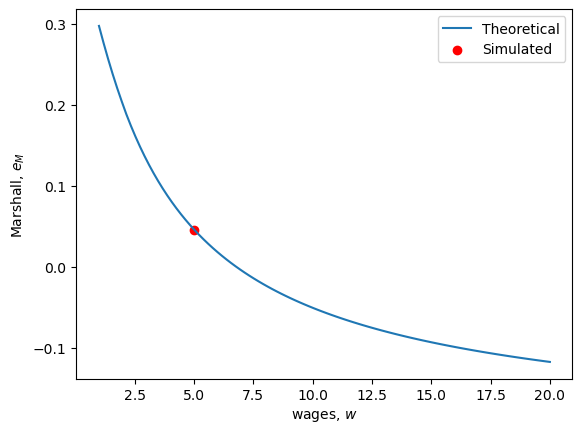

In [17]:
# plot
fig, ax = plt.subplots()
ax.plot(par.w_grid,ela_M,label='Theoretical');
ax.scatter(w,ela_M_sim,color='red',label='Simulated');
ax.set(xlabel='wages, $w$',ylabel='Marshall, $e_{M}$');
ax.legend();

**Income effect**

In [18]:
# Theoretical
ei = par.eta*S/(par.gamma - par.eta*S) 

In [19]:
# Solve and simulate model with slightly higher non-labor income
h_N = solve(N*1.01,par)
h_sim_1pct_N = simulate(w,h_N,par)

ela_I_sim = (h_sim_1pct_N-h_sim_base)/h_sim_base*100
ei_sim = w*h_sim_base*(1-par.tau)* ela_I_sim / N

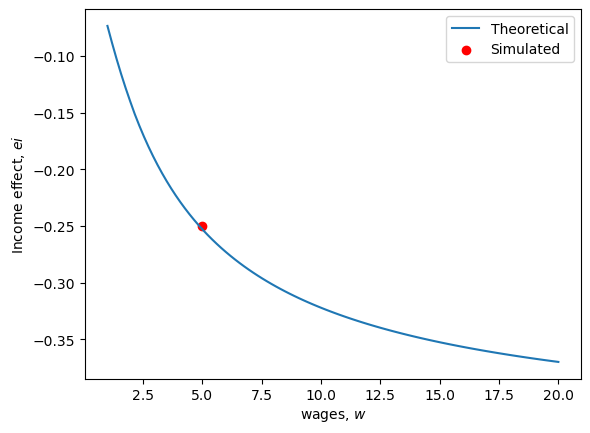

In [20]:
# plot
fig, ax = plt.subplots()
ax.plot(par.w_grid,ei,label='Theoretical');
ax.scatter(w,ei_sim,color='red',label='Simulated');
ax.set(xlabel='wages, $w$',ylabel='Income effect, $ei$');
ax.legend();

**Hicks, compensated elasticity**

In [21]:
# Theoretical
ela_H = 1/(par.gamma - par.eta*S)

In [23]:
# Hicks: Compensate (or use Slutsky, which is much easier)
def util_diff(comp,h_base,w,N,par):
    
    util_base = util(h_base,w,N,par)
    
    # alternative model: increase wage by 1% but compensate via non-labor income
    N_alt = N + comp
    w_alt = w*1.01
    
    h_alt_vec = solve(N_alt,par)
    h_alt = simulate(w_alt,h_alt_vec,par)
    util_alt = util(h_alt,w_alt,N_alt,par)
    
    return util_base - util_alt

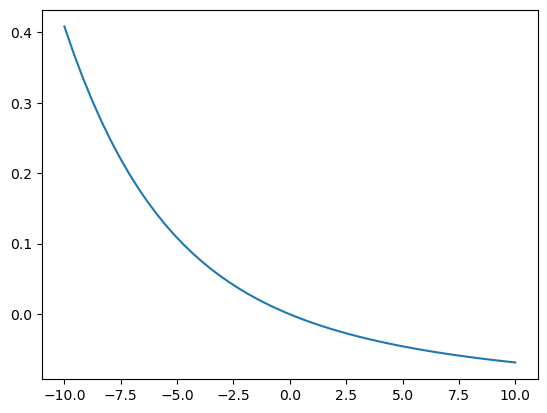

In [27]:
n_grid = np.linspace(-10, 10, 50)
u_grid = [util_diff(n,h_sim_base, w, N, par) for n in n_grid]
plt.plot(n_grid, u_grid)

In [30]:
# find the compensation that equalize utility to baseline level
obj = lambda comp: 1000.0*util_diff(comp,h_sim_base,w,N,par)**2 # squared utility difference (scaled)
res = minimize(obj,0.0)
comp = res.x[0]

print(f'Compensation: {comp:2.4f}. Resulting utility difference: {util_diff(comp,h_sim_base,w,N,par):2.2g}')

Compensation: -0.0367. Resulting utility difference: -6e-08


In [31]:
# calculate elasticity with this level of compensation
h_H = solve(N+comp,par)
h_sim_1pct_H = simulate(w*1.01,h_H,par)
ela_H_sim = (h_sim_1pct_H-h_sim_base)/h_sim_base*100

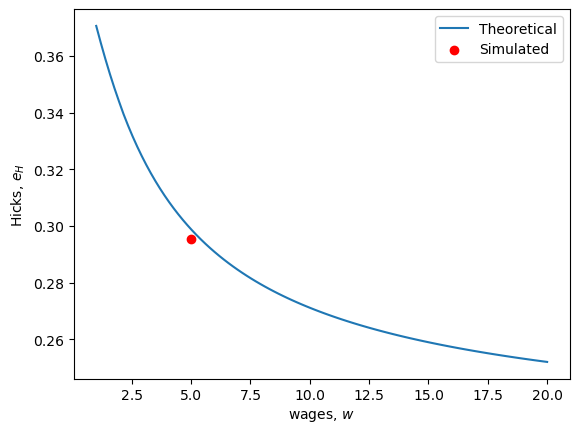

In [32]:
# plot
fig, ax = plt.subplots()
ax.plot(par.w_grid,ela_H,label='Theoretical');
ax.scatter(w,ela_H_sim,color='red',label='Simulated');
ax.set(xlabel='wages, $w$',ylabel='Hicks, $e_H$');
ax.legend();

## In-Class Exercise
Imagine that there is 1,000 heterogeneous agents with individual levels of wages, $w_i$ for $i=1,\dots,1,000$. The distribution of wages is uniform on $[2.5,10.0]$. 

What is the average Marshall elasticity in the population? <br>
\[*hint:* you can calculate this by simulation using `np.randon.uniform`\]

In [72]:
n = 1000
w_max = 10.0
w_min = 2.5
N = 5

#h = solve(N, par)
np.random.seed(2023)
wi = np.random.uniform(w_min, w_max, size=n)

sim_base_grid = np.array([simulate(w, h, par) for w in wi])
sim_alt_grid  = np.array([simulate(w*(1.01), h, par) for w in wi])

el_grid = (sim_alt_grid/sim_base_grid-1)*100
print(f'Avg. Marshall elasticity = {el_grid.mean():5.4f}')

Avg. Marshall elasticity = 0.0213


In [71]:
# solution
n = 1000

# draw uniform wages
np.random.seed(2023)
wi = np.random.uniform(2.5,10.0,size=n)

# find baseline optimal labor supply and alternative
hi_base = np.nan + np.ones(n)
hi_1pct = np.nan + np.ones(n)
for i in range(n):
    hi_base[i] = simulate(wi[i],h,par)
    hi_1pct[i] = simulate(wi[i]*1.01,h,par)
    
# individual elasticities
ela_M_i = (hi_1pct-hi_base)/hi_base*100

# average
print(f'Average Marshall: {np.mean(ela_M_i):2.3f}')

Average Marshall: 0.021


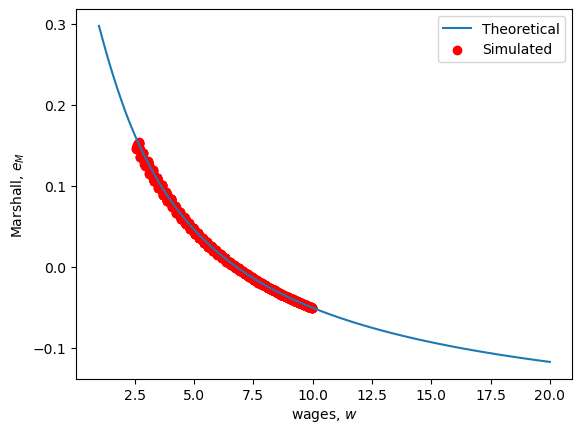

In [66]:
# plot individual with theoretical
fig, ax = plt.subplots()
ax.plot(par.w_grid,ela_M,label='Theoretical');
ax.scatter(wi,ela_M_i,color='red',label='Simulated');
ax.set(xlabel='wages, $w$',ylabel='Marshall, $e_{M}$');
ax.legend();